
# Recording objects

The :py:class:`~spikeinterface.core.BaseRecording` is the basic class for handling recorded data.
Here is how it works.

A RecordingExtractor handles:

  * traces retrieval across segments
  * dumping to/loading from dict-json
  * saving (caching)


In [1]:
import matplotlib.pyplot as plt

import numpy as np
import spikeinterface.extractors as se

c:\Users\user\anaconda3\envs\intan\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will create a :code:`RecordingExtractor` object from scratch using :code:`numpy` and the
:py:class:`~spikeinterface.core.NumpyRecording`.

Let's define the properties of the dataset:



In [2]:
num_channels = 7
sampling_frequency = 30000.0  # in Hz
durations = [10.0, 15.0]  # in s for 2 segments
num_segments = 2
num_timepoints = [int(sampling_frequency * d) for d in durations]

We can generate a pure-noise timeseries dataset for 2 segments with 2
different durations:



In [3]:
traces0 = np.random.normal(0, 10, (num_timepoints[0], num_channels))
traces1 = np.random.normal(0, 10, (num_timepoints[1], num_channels))

And instantiate a :py:class:`~spikeinterface.core.NumpyRecording`. Each object has a pretty print to
summarize its content:



In [4]:
recording = se.NumpyRecording(traces_list=[traces0, traces1], sampling_frequency=sampling_frequency)
print(recording)

NumpyRecording: 7 channels - 30.0kHz - 2 segments - 750,000 samples - 25.00s - float64 dtype 
                40.05 MiB
Segments:
Samples:   300,000 | 450,000
Durations: 10.00s | 15.00s
Memory:    16.02 MiB | 24.03 MiB


We can now print properties that the :code:`RecordingExtractor` retrieves from the underlying recording.



In [5]:
print(f"Number of channels = {len(recording.get_channel_ids())}")
print(f"Sampling frequency = {recording.get_sampling_frequency()} Hz")
print(f"Number of segments= {recording.get_num_segments()}")
print(f"Number of timepoints in seg0= {recording.get_num_frames(segment_index=0)}")
print(f"Number of timepoints in seg1= {recording.get_num_frames(segment_index=1)}")

Number of channels = 7
Sampling frequency = 30000.0 Hz
Number of segments= 2
Number of timepoints in seg0= 300000
Number of timepoints in seg1= 450000


The geometry of the Probe is handled with the :probeinterface:`ProbeInterface <>` library.
Let's generate a linear probe by specifying our number of electrodes/contacts (num_elec)
the distance between the contacts (ypitch), their shape (contact_shapes) and their size
(contact_shape_params):



(<matplotlib.collections.PolyCollection at 0x2b145e9eb70>,
 <matplotlib.collections.PolyCollection at 0x2b145c0af00>)

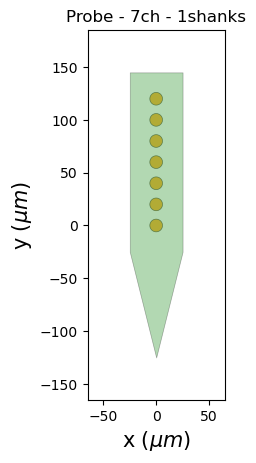

In [6]:
from probeinterface import generate_linear_probe
from probeinterface.plotting import plot_probe

probe = generate_linear_probe(num_elec=7, ypitch=20, contact_shapes="circle", contact_shape_params={"radius": 6})

# the probe has to be wired to the recording device (i.e., which electrode corresponds to an entry in the data
# matrix)
probe.set_device_channel_indices(np.arange(7))

# then we need to actually set the probe to the recording object
recording = recording.set_probe(probe)
plot_probe(probe)

Some extractors also implement a :code:`write` function.



In [7]:
file_paths = ["traces0.raw", "traces1.raw"]
se.BinaryRecordingExtractor.write_recording(recording, file_paths)

c:\Users\user\anaconda3\envs\intan\Lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(
write_binary_recording: 100%|##########| 25/25 [00:00<00:00, 606.82it/s]


We can read the written recording back with the proper extractor.
Note that this new recording is now "on disk" and not "in memory" as the Numpy recording was.
This means that the loading is "lazy" and the data are not loaded into memory.



In [8]:
recording2 = se.BinaryRecordingExtractor(
    file_paths=file_paths, sampling_frequency=sampling_frequency, num_channels=num_channels, dtype=traces0.dtype
)
print(recording2)

BinaryRecordingExtractor: 7 channels - 30.0kHz - 2 segments - 750,000 samples - 25.00s 
                          float64 dtype - 40.05 MiB
Segments:
Samples:   300,000 | 450,000
Durations: 10.00s | 15.00s
Memory:    16.02 MiB | 24.03 MiB
  file_paths: ['c:\\Users\\user\\sean\\Spike-sorter-LINK\\traces0.raw', 'c:\\Users\\user\\sean\\Spike-sorter-LINK\\traces1.raw']


Loading traces in memory is done on demand:



In [9]:
# entire segment 0
traces0 = recording2.get_traces(segment_index=0)
# part of segment 1
traces1_short = recording2.get_traces(segment_index=1, end_frame=50)
print(traces0.shape)
print(traces1_short.shape)

(300000, 7)
(50, 7)


Internally, a recording has :code:`channel_ids`: that are a vector that can have a
dtype of :code:`int` or :code:`str`:



In [10]:
print("chan_ids (dtype=int):", recording.get_channel_ids())

recording3 = se.NumpyRecording(
    traces_list=[traces0, traces1],
    sampling_frequency=sampling_frequency,
    channel_ids=["a", "b", "c", "d", "e", "f", "g"],
)
print("chan_ids (dtype=str):", recording3.get_channel_ids())

chan_ids (dtype=int): [0 1 2 3 4 5 6]
chan_ids (dtype=str): ['a' 'b' 'c' 'd' 'e' 'f' 'g']


:code:`channel_ids` are used to retrieve information (e.g. traces) only on a
subset of channels:



In [11]:
traces = recording3.get_traces(segment_index=1, end_frame=50, channel_ids=["a", "d"])
print(traces.shape)

(50, 2)


You can also get a recording with a subset of channels (i.e. a channel slice):



In [12]:
recording4 = recording3.channel_slice(channel_ids=["a", "c", "e"])
print(recording4)
print(recording4.get_channel_ids())

# which is equivalent to
from spikeinterface import ChannelSliceRecording

recording4 = ChannelSliceRecording(recording3, channel_ids=["a", "c", "e"])

ChannelSliceRecording: 3 channels - 30.0kHz - 2 segments - 750,000 samples - 25.00s 
                       float64 dtype - 17.17 MiB
Segments:
Samples:   300,000 | 450,000
Durations: 10.00s | 15.00s
Memory:    6.87 MiB | 10.30 MiB
['a' 'c' 'e']


Another possibility is to split a recording based on a certain property (e.g. 'group')



In [13]:
recording3.set_property("group", [0, 0, 0, 1, 1, 1, 2])

recordings = recording3.split_by(property="group")
print(recordings)
print(recordings[0].get_channel_ids())
print(recordings[1].get_channel_ids())
print(recordings[2].get_channel_ids())

{0: ChannelSliceRecording: 3 channels - 30.0kHz - 2 segments - 750,000 samples - 25.00s 
                       float64 dtype - 17.17 MiB
Segments:
Samples:   300,000 | 450,000
Durations: 10.00s | 15.00s
Memory:    6.87 MiB | 10.30 MiB, 1: ChannelSliceRecording: 3 channels - 30.0kHz - 2 segments - 750,000 samples - 25.00s 
                       float64 dtype - 17.17 MiB
Segments:
Samples:   300,000 | 450,000
Durations: 10.00s | 15.00s
Memory:    6.87 MiB | 10.30 MiB, 2: ChannelSliceRecording: 1 channels - 30.0kHz - 2 segments - 750,000 samples - 25.00s 
                       float64 dtype - 5.72 MiB
Segments:
Samples:   300,000 | 450,000
Durations: 10.00s | 15.00s
Memory:    2.29 MiB | 3.43 MiB}
['a' 'b' 'c']
['d' 'e' 'f']
['g']


A recording can be "dumped" (exported) to:
 * a dict
 * a json file
 * a pickle file

The "dump" operation is lazy, i.e., the traces are not exported.
Only the information about how to reconstruct the recording are dumped:



In [14]:
from spikeinterface import load_extractor
from pprint import pprint

d = recording2.to_dict()
pprint(d)

recording2_loaded = load_extractor(d)
print(recording2_loaded)

{'annotations': {'is_filtered': False, 'name': None},
 'class': 'spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor',
 'kwargs': {'channel_ids': [0, 1, 2, 3, 4, 5, 6],
            'dtype': '<f8',
            'file_offset': 0,
            'file_paths': ['c:\\Users\\user\\sean\\Spike-sorter-LINK\\traces0.raw',
                           'c:\\Users\\user\\sean\\Spike-sorter-LINK\\traces1.raw'],
            'gain_to_uV': None,
            'is_filtered': None,
            'num_channels': 7,
            'offset_to_uV': None,
            'sampling_frequency': 30000.0,
            't_starts': None,
            'time_axis': 0},
 'module': 'spikeinterface',
 'properties': {'gain_to_uV': None,
                'group': None,
                'location': None,
                'offset_to_uV': None},
 'relative_paths': False,
 'version': '0.101.2'}
BinaryRecordingExtractor: 7 channels - 30.0kHz - 2 segments - 750,000 samples - 25.00s 
                          float64 dtype - 40.05 

The dictionary can also be dumped directly to a JSON file on disk:



In [15]:
recording2.dump("my_recording.json")

recording2_loaded = load_extractor("my_recording.json")
print(recording2_loaded)

BinaryRecordingExtractor: 7 channels - 30.0kHz - 2 segments - 750,000 samples - 25.00s 
                          float64 dtype - 40.05 MiB
Segments:
Samples:   300,000 | 450,000
Durations: 10.00s | 15.00s
Memory:    16.02 MiB | 24.03 MiB
  file_paths: ['c:\\Users\\user\\sean\\Spike-sorter-LINK\\traces0.raw', 'c:\\Users\\user\\sean\\Spike-sorter-LINK\\traces1.raw']


**IMPORTANT**: the "dump" operation DOES NOT copy the traces to disk!

If you wish to also store the traces in a compact way you need to use the
:code:`save()` function. This operation is very useful to save traces obtained
after long computations (e.g. filtering or referencing):



In [16]:
recording2.save(folder="./my_recording")

import os

pprint(os.listdir("./my_recording"))

recording2_cached = load_extractor("my_recording.json")
print(recording2_cached)

write_binary_recording 
n_jobs=1 - samples_per_chunk=30,000 - chunk_memory=1.60 MiB - total_memory=1.60 MiB - chunk_duration=1.00s


write_binary_recording: 100%|##########| 25/25 [00:00<00:00, 416.75it/s]


['binary.json',
 'properties',
 'provenance.json',
 'si_folder.json',
 'traces_cached_seg0.raw',
 'traces_cached_seg1.raw']
BinaryRecordingExtractor: 7 channels - 30.0kHz - 2 segments - 750,000 samples - 25.00s 
                          float64 dtype - 40.05 MiB
Segments:
Samples:   300,000 | 450,000
Durations: 10.00s | 15.00s
Memory:    16.02 MiB | 24.03 MiB
  file_paths: ['c:\\Users\\user\\sean\\Spike-sorter-LINK\\traces0.raw', 'c:\\Users\\user\\sean\\Spike-sorter-LINK\\traces1.raw']
